# Bibliotecas

Nesta seção vamos instalar todas as bibliotecas utilizadas.

Além do OpenStreetMap, foram utilizadas: geopandas, pandas e networkx, mas estas já estão disponíveis no jupyter.

In [ ]:
!pip install osmnx

# Preparação

Nesta seção, vamos preparar o grafo com os dados recolhidos [neste repositório](https://github.com/lemuel-manske/city-block/tree/main/data) e organizar vértices e arestas por bairro.

In [122]:
BLUMENAU = 'Blumenau, Brazil'
TIMBO = 'Timbó, Brazil'
INDAIAL = 'Indaial, Brazil'

In [123]:
from typing import Union

import pandas as pd
import geopandas as gpd

import folium as fl

import osmnx as ox
import networkx as nx

import matplotlib.pyplot as plt

1. Gerar o grafo composto de Blumenau, Timbó e Indaial (integrantes Lemuel e Lucas são de Blumenau e Rodrigo de Timbó, por isso optamos por manter o vértice em Timbó)

In [124]:
'''
  Get's graph from a given `place`.
'''
def get_graph_from_place(place: str):
  return ox.graph_from_place(
    place,
    network_type='drive'
  )

In [125]:
def make_source_graph() -> nx.MultiDiGraph:
  return nx.compose_all([
    get_graph_from_place(BLUMENAU),
    get_graph_from_place(TIMBO),
    get_graph_from_place(INDAIAL)
  ])

G = make_source_graph()

2. Importar os dados recolhidos para o grafo. Para este processo, foram coletadas longitude - `x` - e latitude - `y` - de cada ponto de interesse e no grafo vamos atribuir um "label" e "nome" para o vértice mais próximo ao ponto de interesse desejado. Todos os datasets estão disponíveis [neste repositório](http://github.com/lemuel-manske/city-block/data)
  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.distance.nearest_nodes

In [126]:
ESTUDANTE_TAG = 'estudante'

HOSPITAL_TAG = 'hospital'
CRECHE_TAG = 'creche'
ESCOLA_TAG = 'escola'
PONTO_SAUDE_TAG = 'ponto_saude'
PSICOSSOCIAL_TAG = 'psicossocial'

ALL_SERVICE_TAGS = [
  HOSPITAL_TAG,
  CRECHE_TAG,
  ESCOLA_TAG,
  PONTO_SAUDE_TAG,
  PSICOSSOCIAL_TAG
]

BAIRROS_BLUMENAU_TAG = 'bairros_blumenau'
BAIRROS_TIMBO_TAG = 'bairros_timbo'

In [127]:
REPOSITORY = 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data'

DATASETS = {
    HOSPITAL_TAG: REPOSITORY + '/hospitais.csv',
    ESTUDANTE_TAG: REPOSITORY + '/estudantes.csv',
    CRECHE_TAG: REPOSITORY + '/creches.csv',
    ESCOLA_TAG: REPOSITORY + '/escolas.csv',
    PONTO_SAUDE_TAG: REPOSITORY + '/pontos_saude.csv',
    PSICOSSOCIAL_TAG: REPOSITORY + '/centros_psicossociais.csv',
    BAIRROS_BLUMENAU_TAG: REPOSITORY + '/bairros_blumenau.csv',
    BAIRROS_TIMBO_TAG: REPOSITORY + '/bairros_timbo.csv'
}

DATAFRAMES = {
    HOSPITAL_TAG: pd.read_csv(DATASETS[HOSPITAL_TAG]),
    ESTUDANTE_TAG: pd.read_csv(DATASETS[ESTUDANTE_TAG]),
    CRECHE_TAG: pd.read_csv(DATASETS[CRECHE_TAG]),
    ESCOLA_TAG: pd.read_csv(DATASETS[ESCOLA_TAG]),
    PONTO_SAUDE_TAG: pd.read_csv(DATASETS[PONTO_SAUDE_TAG]),
    PSICOSSOCIAL_TAG: pd.read_csv(DATASETS[PSICOSSOCIAL_TAG]),
    BAIRROS_BLUMENAU_TAG: pd.read_csv(DATASETS[BAIRROS_BLUMENAU_TAG]),
    BAIRROS_TIMBO_TAG: pd.read_csv(DATASETS[BAIRROS_TIMBO_TAG])
}

In [128]:
def load_all_data_sets(graph: nx.MultiDiGraph = G):

  def desserialize(value: str) -> Union[str, bool]:
    if value == 'yes':
      return True

    if value == 'no':
      return False

    return value

  def label_points_of_interest(dataframe: pd.DataFrame, label: str, tags: list[str]):
    for idx, row in dataframe.iterrows():
      nearest_node_from_interest_point = ox.distance.nearest_nodes(graph, X=row['x'], Y=row['y'])

      graph.nodes[nearest_node_from_interest_point]['label'] = label

      for tag in tags:
        graph.nodes[nearest_node_from_interest_point][tag] = desserialize(row[tag])

  def load_data_set(label: str, tags: list[str]):
    label_points_of_interest(DATAFRAMES[label], label, tags)

  load_data_set(ESTUDANTE_TAG,    ['ref', 'student_name'])
  load_data_set(HOSPITAL_TAG,     ['name', 'is_public'])
  load_data_set(CRECHE_TAG,       ['name', 'is_public'])
  load_data_set(ESCOLA_TAG,       ['name', 'is_public'])
  load_data_set(PONTO_SAUDE_TAG,  ['name', 'is_public'])
  load_data_set(PSICOSSOCIAL_TAG, ['name', 'is_public'])

In [129]:
load_all_data_sets()

3. Afim de facilitar a análise, vamos separar todas os vértices e arestas por bairro. Foi necessário remover os bairros que não são reconhecidos na divisão administrativa feita pela prefeitura [neste link](https://www.blumenau.sc.gov.br/secretarias/secretaria-de-desenvolvimento-urbano/pagina/historia-sobre-municipio/divisa-administrativa-bairros) mas que o OSM reconhece.

  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_place
  - https://wiki.openstreetmap.org/wiki/Key:admin_level

Bairros por nome e população (fonte: Censo 2022)

In [130]:
def get_neighborhoods(place: str, places_to_filter: list[str]):
  return ox.features.features_from_place(place, {'admin_level': '10'}) \
    .query(f'name in {list(places_to_filter)}')

neighborhoods = pd \
  .concat([
    get_neighborhoods(BLUMENAU, DATAFRAMES[BAIRROS_BLUMENAU_TAG]['name']),
    get_neighborhoods(TIMBO, DATAFRAMES[BAIRROS_TIMBO_TAG]['name'])
  ]) \
    .merge(DATAFRAMES[BAIRROS_BLUMENAU_TAG][['name', 'hab']], on='name', how='left')

4. Com o geopandas, podemos fazer um [*spatial join*](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin) dos vértices - `G_nodes` - do grafo original que sobrepoem - `predicate='intersects'` - qualquer polígono - `neighborhoods[['geometry']]`. Por fim, renomeamos a coluna de `name_right` para `name` para manter consistência. A saída são todos os vértices de `G`, porém agora estão identificados por bairro.

 - https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html


In [131]:
def nodes_with_neighborhood(graph: nx.MultiDiGraph = G):
  nodes, _ = ox.graph_to_gdfs(graph)

  return gpd \
    .sjoin(nodes, neighborhoods[['name', 'geometry']], how='left', predicate='intersects') \
    .rename(columns={'name_right': 'name'})['name']

In [132]:
nx.set_node_attributes(G, nodes_with_neighborhood().to_dict(), 'neighborhood_name')

In [133]:
def get_labeled_nodes(label: str, graph: nx.MultiDiGraph = G):
  nodes, _ = ox.graph_to_gdfs(graph)

  return nodes[nodes['label'] == label]

In [134]:
def get_student_node_id(student_name: str):
  students = get_labeled_nodes(ESTUDANTE_TAG)

  student_node = students[students['student_name'] == student_name]

  return student_node.index[0]

In [135]:
def closest_service_from_student(student_name: str, target_service: str, graph: nx.MultiDiGraph = G) -> list[int]:
  start = get_student_node_id(student_name)

  target_nodes = get_labeled_nodes(target_service)

  curr_path_dist = None
  curr_shortest_path = None

  for _, hospital in target_nodes.iterrows():
    end = hospital.name

    new_path = nx.dijkstra_path(graph, start, end, weight='length')

    new_path_dist = nx.dijkstra_path_length(G, start, end)

    if curr_path_dist is None:
      curr_path_dist = new_path_dist
      curr_shortest_path = new_path

    elif new_path_dist < curr_path_dist:
      curr_path_dist = new_path_dist
      curr_shortest_path = new_path

  return curr_shortest_path

In [136]:
def center(nodes: gpd.GeoDataFrame):
  return nodes.geometry.union_all().centroid

In [137]:
def get_node_location(node) -> tuple[float, float]:
  return (node['y'], node['x'])

In [138]:
G_nodes, G_edges = ox.graph_to_gdfs(G)

G_center = center(G_nodes)

# Análise

Nesta seção vamos gerar informações a partir dos dados coletados anteriormente.

In [139]:
'''
  Makes a folium map labelling out all points of interest.
'''
def make_map(graph: nx.MultiDiGraph = G):

  def line_off_neighborhoods(m):
    fields = ['name']

    fl.GeoJson(
      neighborhoods.to_json(),
      name='Bairros',
      tooltip=fl.GeoJsonTooltip(labels=False, fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_students(m):
    fields = ['student_name', 'name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='blue', icon='home')
    )

    fl.GeoJson(
      get_labeled_nodes(ESTUDANTE_TAG, graph),
      name='Estudantes',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_hospitals(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='red', icon='h-square', prefix='fa')
    )

    hospitals = get_labeled_nodes(HOSPITAL_TAG, graph)

    if hospitals.empty:
      return

    fl.GeoJson(
      hospitals,
      name='Hospitais',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_childcare(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='green', icon='child', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(CRECHE_TAG, graph),
      name='Creches',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)

    ).add_to(m)


  def mark_out_schools(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='orange', icon='graduation-cap', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(ESCOLA_TAG, graph),
      name='Escolas',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_psychosocial_care(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='purple', icon='user-md', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(PSICOSSOCIAL_TAG, graph),
      name='Centro de Psicossocial',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_points_of_care(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='gray', icon='medkit', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(PONTO_SAUDE_TAG, graph),
      name='Pontos de Saúde',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)

  nodes, edges = ox.graph_to_gdfs(graph)

  c = center(nodes)

  map = fl.Map(location=[c.y, c.x], zoom_start=14)

  line_off_neighborhoods(map)

  mark_out_students(map)
  mark_out_hospitals(map)
  mark_out_childcare(map)
  mark_out_schools(map)
  mark_out_psychosocial_care(map)
  mark_out_points_of_care(map)

  return map

In [140]:
m = make_map(G)

fl.LayerControl() \
  .add_to(m)

m

A partir da residência de cada integrante da equipe, quantos serviços públicos estão disponíveis num raio de 1km, 5km e 10km?

In [141]:
def get_graph_of_services(student_name: str, distance: int, graph: nx.MultiDiGraph = G) -> nx.MultiDiGraph:

  def get_services_in_graph(graph: nx.MultiDiGraph) -> list[int]:
    services_in_graph = []

    nodes, _ = ox.graph_to_gdfs(graph)

    for idx, node in nodes.iterrows():
      if node['label'] in ALL_SERVICE_TAGS:
        services_in_graph.append(idx)

    return services_in_graph

  student_node = get_student_node_id(student_name)

  services_graph = ox.truncate \
    .truncate_graph_dist(graph, student_node, dist=distance, weight='length')

  services = get_services_in_graph(services_graph)

  load_all_data_sets(services_graph)

  return services_graph

In [146]:
def make_map_of_services_in_distance(
    student_name: str,
    radiuses: dict[int, str] = { 1000: 'red', 5000: 'blue', 10000: 'orange' }):
  G_services_nearby_student = get_graph_of_services(student_name, max(radiuses))

  map = make_map(G_services_nearby_student)

  student_node = G_services_nearby_student \
    .nodes[get_student_node_id(student_name)]

  location = get_node_location(student_node)

  for k in radiuses:
    k_name = f'{k} metros'

    group = fl.FeatureGroup(k_name)

    fl.Circle(
      location=location,
      radius=k,
      weight=0,
      fill_opacity=0.25,
      opacity=1,
      fill_color=radiuses[k],
      fill=False,
      tooltip=k_name
    ).add_to(group)

    group.add_to(map)

  return map

In [147]:
m = make_map_of_services_in_distance('lemuel')

fl.LayerControl() \
  .add_to(m)

m

Serviços por bairro:

In [164]:
def count_services_by_neighborhood(graph: nx.MultiDiGraph = G):
  service_counts = {}

  for service_tag in ALL_SERVICE_TAGS:
    labeled_nodes = get_labeled_nodes(service_tag, graph)

    service_counts[service_tag] = labeled_nodes.groupby('neighborhood_name') \
      .size() \
      .reset_index(name='count')

  return service_counts

In [165]:
service_counts = count_services_by_neighborhood(G)

In [166]:
all_service_counts_df = pd.concat([
  df.set_index('neighborhood_name') for df in service_counts.values()
], axis=1) \
  .fillna(0) \
  .astype(int)

all_service_counts_df.columns = ALL_SERVICE_TAGS

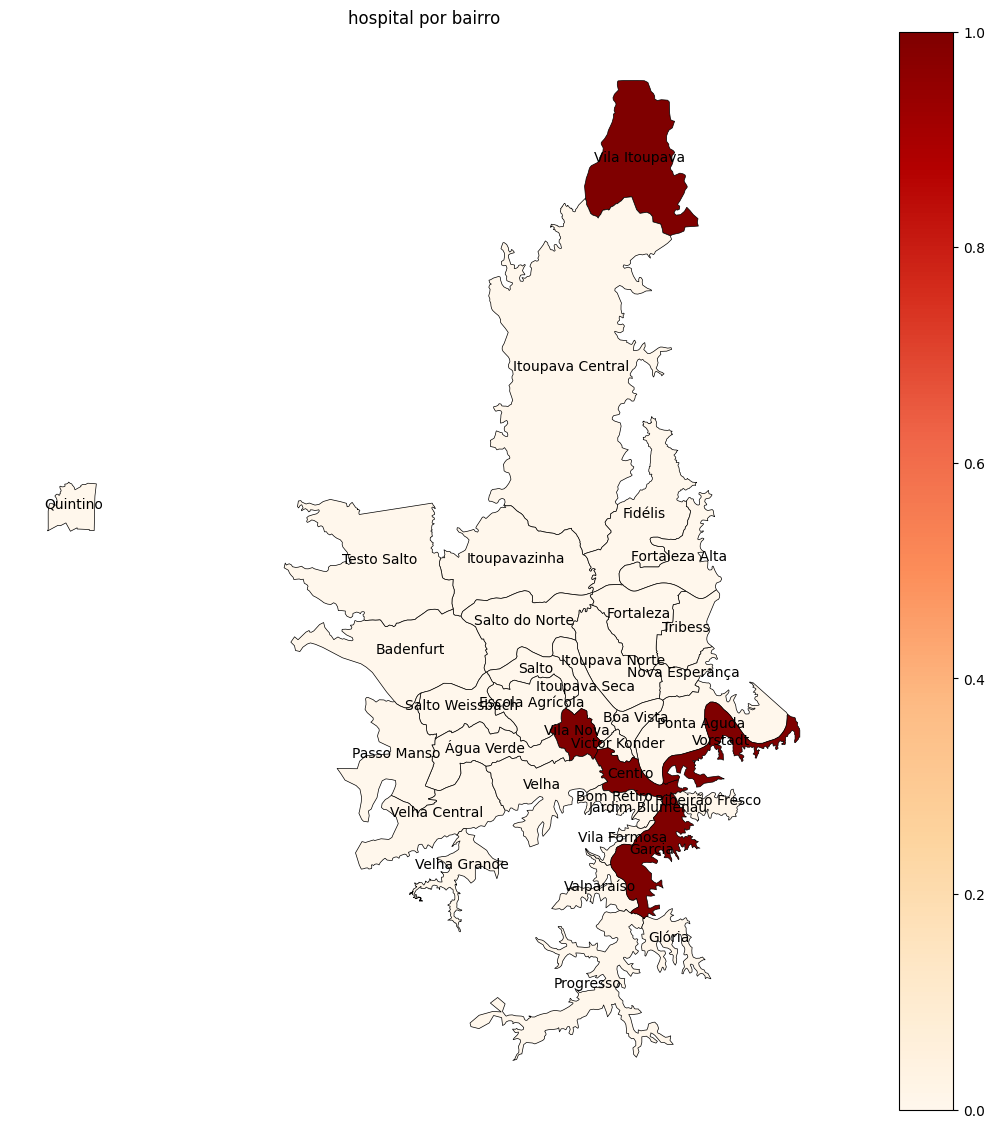

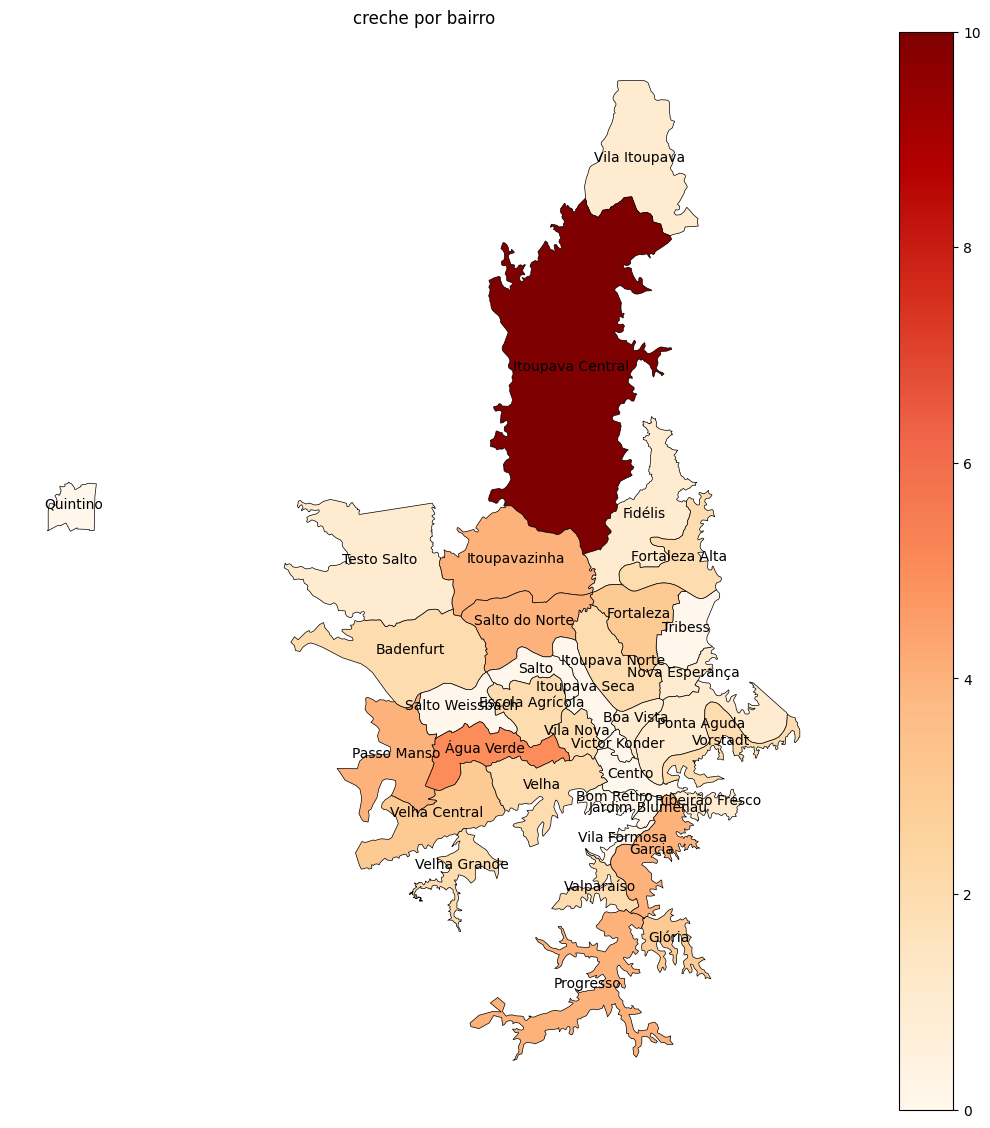

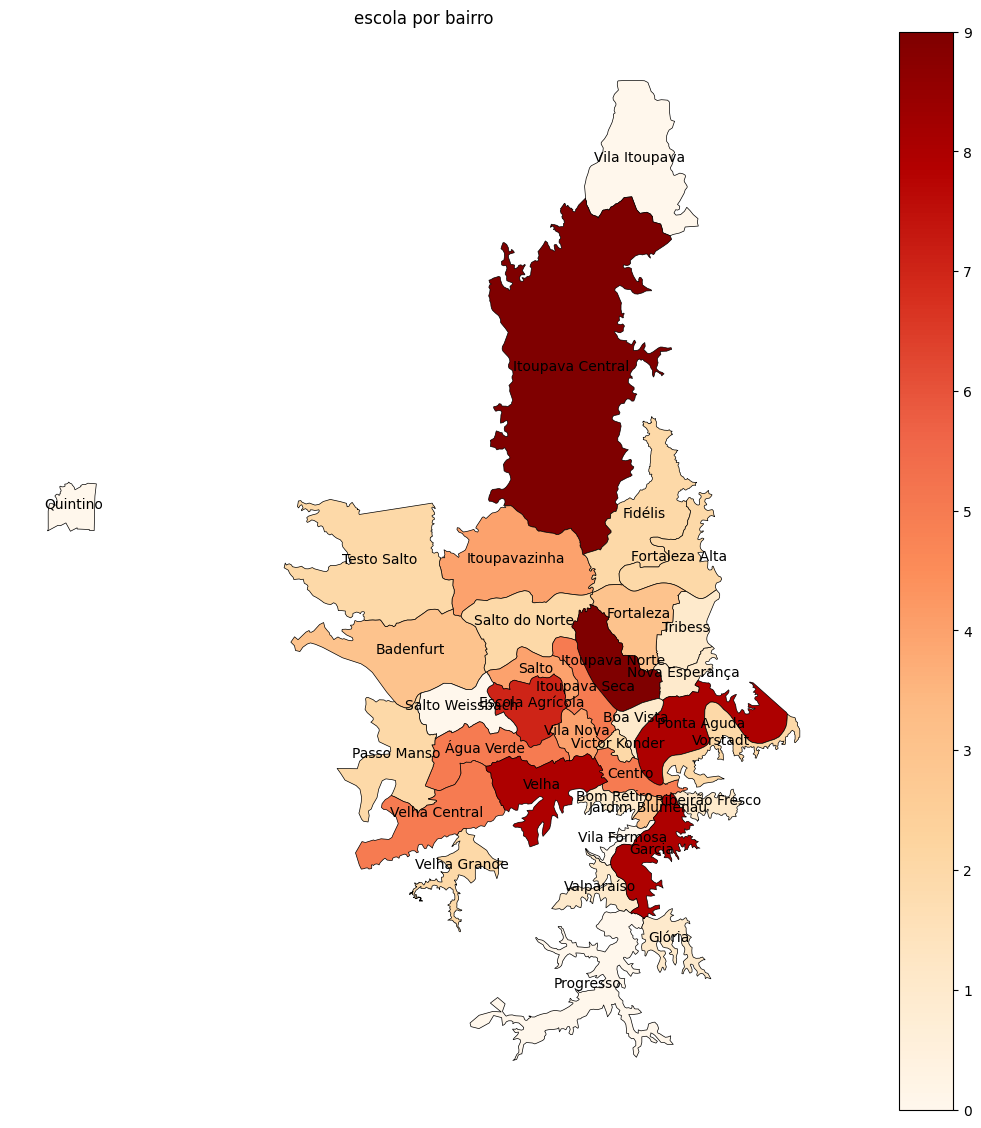

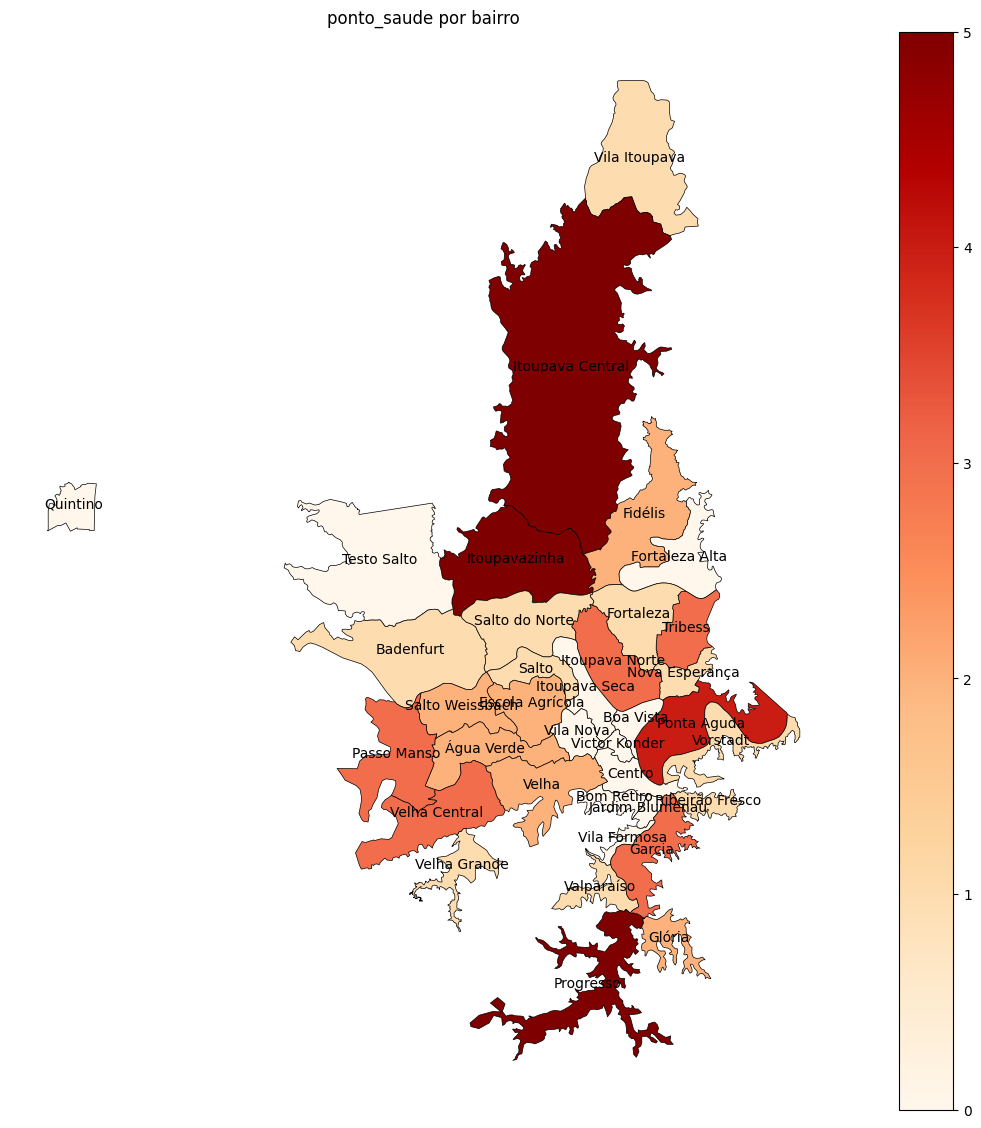

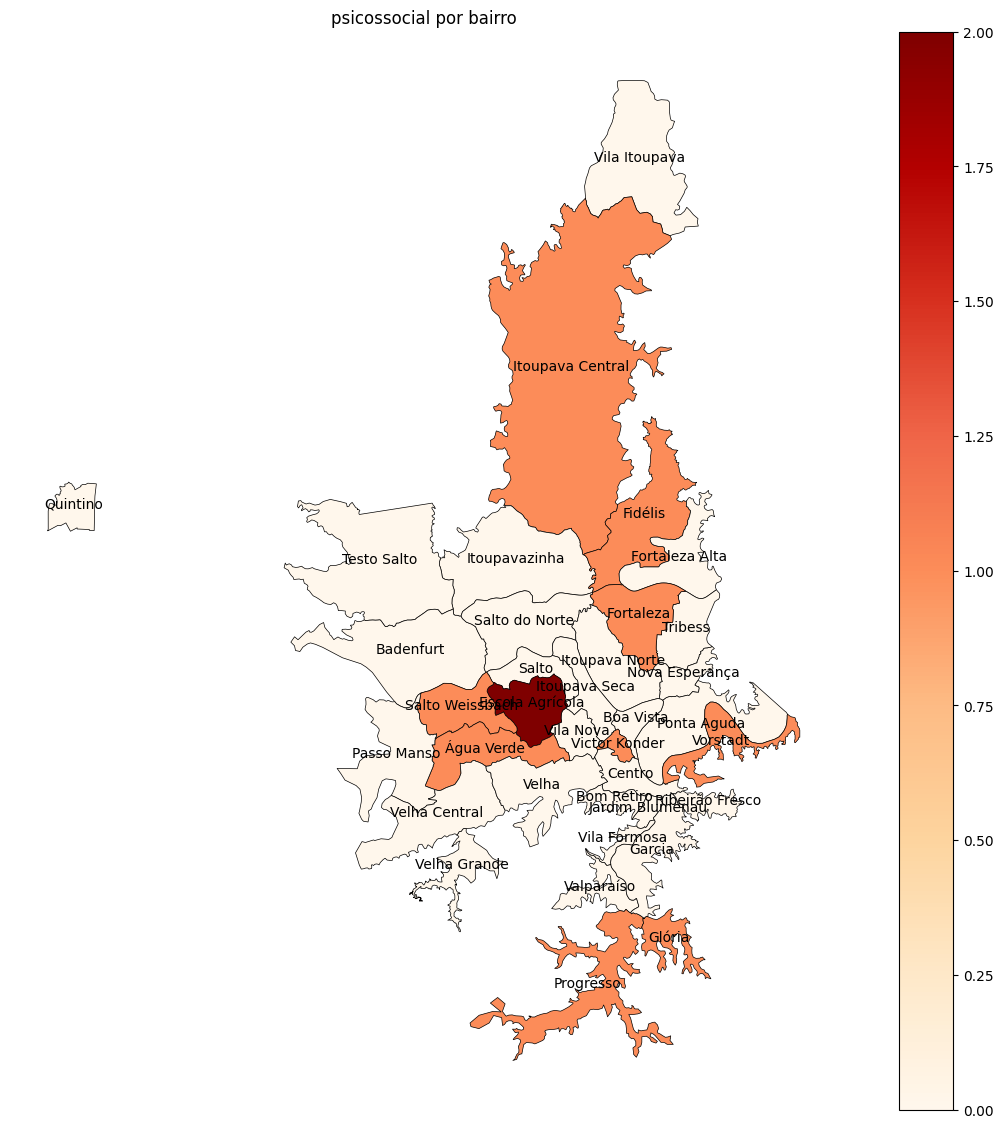

In [175]:
for service_tag in ALL_SERVICE_TAGS:
  if service_counts[service_tag] is None or service_counts[service_tag].empty:
    break

  neighborhoods_with_counts = neighborhoods \
    .merge(service_counts[service_tag], left_on='name', right_on='neighborhood_name', how='left')

  neighborhoods_with_counts['count'] = neighborhoods_with_counts['count'] \
    .fillna(0)

  fig, ax = plt.subplots(1, 1, figsize=(16, 14))

  neighborhoods_with_counts.plot(
    ax=ax,
    column='count',

    legend=True,
    cmap='OrRd',

    edgecolor='black',
    linewidth=0.5,

    legend_kwds={ 'orientation': 'vertical' }
  )

  neighborhoods_with_counts.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

  ax.axis('off')
  ax.set_title(f'{service_tag} por bairro')

  plt.show()
  print('\n')